# Makemore 3: Multi-Layer Perceptron (MLP), activations

**Note**: notebook édité post-cours.

Suite de l'implémentation d'un réseau de neurones inspiré du papier de Bengio et al. de 2003 [_A Neural Probabilistic Language Model_](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

Rappel: code source de [makemore](https://github.com/karpathy/makemore) d'Andrej Karpathy sur Github.

Bibliographie:

- "Kaiming init" paper: <https://arxiv.org/abs/1502.01852>
- BatchNorm paper: <https://arxiv.org/abs/1502.03167>
- Bengio et al. 2003 MLP language model paper (pdf): <https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf>
- Good paper illustrating some of the problems with batchnorm in practice: <https://arxiv.org/abs/2105.07576>


## Reprise du travail précédent

### Imports et données sources

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Words(object):

    def __init__(self, filename):
        self.filename = filename
        self.words = open(self.filename, 'r').read().splitlines()
        self.nb_words = len(self.words)
        self.chars = sorted(list(set(''.join(self.words))))
        self.nb_chars = len(self.chars) + 1  # On ajoute 1 pour EOS
        self.ctoi = {c:i+1 for i,c in enumerate(self.chars)}
        self.ctoi['.'] = 0
        self.itoc = {i:s for s,i in self.ctoi.items()}

    def __repr__(self):
        l = []
        l.append("<Words")
        l.append(f'  filename="{self.filename}"')
        l.append(f'  nb_words="{self.nb_words}"')
        l.append(f'  nb_chars="{self.nb_chars}"/>')
        return '\n'.join(l)

In [3]:
words = Words('civil_mots.txt')
print(words)
print(words.chars)
print("ctoi =", words.ctoi)
print("itoc =", words.itoc)

<Words
  filename="civil_mots.txt"
  nb_words="7223"
  nb_chars="41"/>
["'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ']
ctoi = {"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'â': 29, 'ç': 30, 'è': 31, 'é': 32, 'ê': 33, 'ë': 34, 'î': 35, 'ï': 36, 'ô': 37, 'ù': 38, 'û': 39, 'œ': 40, '.': 0}
itoc = {1: "'", 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'à', 29: 'â', 30: 'ç', 31: 'è', 32: 'é', 33: 'ê', 34: 'ë', 35: 'î', 36: 'ï', 37: 'ô', 38: 'ù', 39: 'û', 40: 'œ', 0:

### Construction du jeu de données pour l'entraînement

In [4]:
def build_dataset(words:list, ctoi: dict, context_size:int):
    """Build the dataset of the neural net for training.

    Parameters:
        words: list of words of our data corpus
        ctoi: mapping of character to int
        context_size: how many characters we take to predict the next one

    Returns:
        X: inputs to the neural net
        Y: labels
    """
    X, Y = [], []
    for w in words:
        context = [0] * context_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

Les mots du code civil générent un jeu d'entraînement avec les entrées `X` de dimension 2 de forme (67652, 3), soit 67652 contextes de 3 caractères différents et pour les labels `Y` 67652 caractères suivants.

In [5]:
context_size = 3
X, Y = build_dataset(words.words, words.ctoi, context_size)
print("X.shape =", X.shape)
print("Y.shape =", Y.shape)
print(X[:5])
print(Y[:5])

X.shape = torch.Size([67652, 3])
Y.shape = torch.Size([67652])
tensor([[0, 0, 0],
        [0, 0, 3],
        [0, 0, 0],
        [0, 0, 3],
        [0, 3, 4]])
tensor([3, 0, 3, 4, 3])


In [6]:
e_dims = 2  # Dimensions des embeddings
C = torch.randn((words.nb_chars, e_dims))
print(C[:5])  # 5 premières lignes

tensor([[-0.5189, -0.3359],
        [ 1.7881,  0.8816],
        [-1.1086, -0.7529],
        [-0.5348,  0.1544],
        [ 0.9513, -0.7199]])


Pour utiliser cette "_lookup table_" sous la forme d'une matrice, on peut l'indexer avec le numéro du caractère dont on souhaite obtenir l'embedding:

In [7]:
emb_char_c = C[5]
print(emb_char_c)

tensor([ 1.0110, -0.6328])


Cette approche est en fait similaire à ce que nous avions fait précédemment avec les vecteurs "one hot":

In [8]:
F.one_hot(torch.tensor(5), num_classes=words.nb_chars).float()

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])

In [9]:
F.one_hot(torch.tensor(5), num_classes=words.nb_chars).float() @ C

tensor([ 1.0110, -0.6328])

La première couche linéaire de ce réseau de neurones, composé de cette matrice C, va être activée avec les indices des caractères.

L'indexation avec des tenseurs Pytorch est très flexible, ce qui permet de récupérer plusiers lignes, par exemple correspondant à la suite de lettres c, a, b (soit 5,3,4):

In [10]:
C[[5,3,4]]

tensor([[ 1.0110, -0.6328],
        [-0.5348,  0.1544],
        [ 0.9513, -0.7199]])

In [11]:
C[[words.ctoi['c'], words.ctoi['a'], words.ctoi['b']]]

tensor([[ 1.0110, -0.6328],
        [-0.5348,  0.1544],
        [ 0.9513, -0.7199]])

On peut également indexer avec un tenseur:

In [12]:
C[torch.tensor([5,3,4])]

tensor([[ 1.0110, -0.6328],
        [-0.5348,  0.1544],
        [ 0.9513, -0.7199]])

Ce tenseur peut être multi-dimensionnel, comme par exemple `X`:

In [13]:
C[X]

tensor([[[-0.5189, -0.3359],
         [-0.5189, -0.3359],
         [-0.5189, -0.3359]],

        [[-0.5189, -0.3359],
         [-0.5189, -0.3359],
         [-0.5348,  0.1544]],

        [[-0.5189, -0.3359],
         [-0.5189, -0.3359],
         [-0.5189, -0.3359]],

        ...,

        [[ 0.1601, -0.4239],
         [-2.8669,  0.5131],
         [-1.1531,  0.7651]],

        [[-2.8669,  0.5131],
         [-1.1531,  0.7651],
         [ 0.5612,  0.1574]],

        [[-1.1531,  0.7651],
         [ 0.5612,  0.1574],
         [-1.1531,  0.7651]]])

In [14]:
C[X].shape

torch.Size([67652, 3, 2])

Ce qui nous permet de créer tous les embeddings:

In [15]:
emb = C[X]

### Réseau complet et entraînement

#### Architecture

In [16]:
class BengioMLP(object):
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.C = torch.randn((nb_chars, e_dims), generator=self.g)
        self.W1 = torch.randn((context_size*e_dims, n_hidden), generator=self.g)
        self.b1 = torch.randn(n_hidden, generator=self.g)
        self.W2 = torch.randn((n_hidden, nb_chars), generator=self.g)
        self.b2 = torch.randn(nb_chars, generator=self.g)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.loss = None

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 + self.b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

In [17]:
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
print(nn)

<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  loss="None"
  nb_parameters="14851"/>


#### Jeux d'entraînement, de développement et de test

In [18]:
# 80%, 10%, 10%
import random
random.seed(42)
shuffled_words = words.words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8*len(shuffled_words))
n2 = int(0.9*len(shuffled_words))

Xtr, Ytr = build_dataset(shuffled_words[:n1], words.ctoi, context_size=context_size)
Xdev, Ydev = build_dataset(shuffled_words[n1:n2], words.ctoi, context_size=context_size)
Xte, Yte = build_dataset(shuffled_words[n2:], words.ctoi, context_size=context_size)

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split, nn):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    loss = nn.compute_loss(x, y)
    print(split, loss.item())

#### Entraînement

In [19]:
def train(X, Y, nn:BengioMLP, max_steps, batch_size):
    lossi = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=nn.g)
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        nn.forward(Xb, Yb)
      
        # backward pass
        nn.backward()
      
        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        nn.update_grad(lr)
    
        # track stats
        if i % 10000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {nn.loss.item():.4f}")
        lossi.append(nn.loss.log10().item())
    return lossi

In [20]:
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
print(nn)
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size) 

<BengioMLP
  nb_chars="41"
  e_dims="10"
  n_hidden="200"
  context_size="3"
  loss="None"
  nb_parameters="14851"/>
      0/ 200000: 35.9341
  10000/ 200000: 2.2655
  20000/ 200000: 1.7284
  30000/ 200000: 1.4077
  40000/ 200000: 1.4658
  50000/ 200000: 1.6519
  60000/ 200000: 1.6968
  70000/ 200000: 1.6052
  80000/ 200000: 1.8488
  90000/ 200000: 1.3902
 100000/ 200000: 1.5850
 110000/ 200000: 1.4387
 120000/ 200000: 1.5193
 130000/ 200000: 1.2574
 140000/ 200000: 1.4510
 150000/ 200000: 1.6283
 160000/ 200000: 1.4135
 170000/ 200000: 1.3451
 180000/ 200000: 1.7981
 190000/ 200000: 1.7184


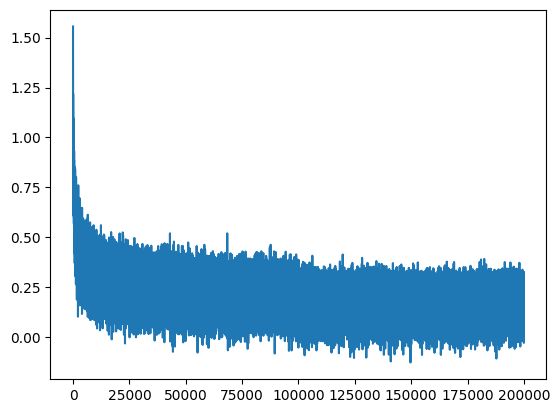

In [21]:
plt.plot(lossi)

In [22]:
split_loss('train', nn)
split_loss('dev', nn)

train 1.4944912195205688
dev 1.7210323810577393


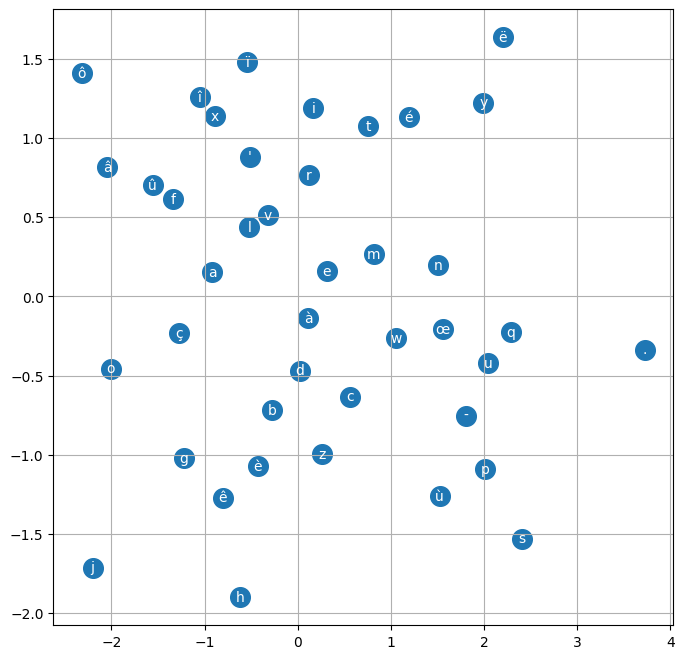

In [23]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(nn.C[:,0].data, C[:,1].data, s=200)
for i in range(nn.C.shape[0]):
    plt.text(nn.C[i,0].item(), C[i,1].item(), words.itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Utilisation du modèle: génération de mots

aves
des
saientients
succèderonor
amments
cultincons
mes
trouverse
achaus
une
organistre-viresoils
accommés
solère
veures
facite
éclarateur
cont
touversoits
recouplie
nionnementretuit

In [24]:
context = [0] * context_size
nn.C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [25]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

@torch.no_grad()
def sample(itoc, nn, g):
    out = []
    context = [0] * nn.context_size
    while True:
        emb = nn.C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ nn.W1 + nn.b1)
        logits = h @ nn.W2 + nn.b2
        probs = F.softmax(logits, dim=1)
        # Sample from the probability distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window
        context = context[1:] + [ix]
        # Store the generated character
        if ix != 0:
            out.append(ix)
        else:
            # Stop when encounting '.'
            break
    return ''.join(itoc[i] for i in out)

for _ in range(20):
    print(sample(words.itoc, nn, g))

aves
des
saientients
succèderonor
amments
cultincons
mes
trouverse
achaus
une
organistre-viresoils
accommés
solère
veures
facite
éclarateur
cont
touversoits
recouplie
nionnementretuit


## Discussion

### Loss initial: première initialisation des poids pour la couche de sortie

En initialisant les poids du réseau de manière aléatoire on a un _loss_ qui est initialisé à une valeur 35, ce qui est beaucoup trop élevé. 

```
      0/ 200000: 35.9341
  10000/ 200000: 2.2655
  20000/ 200000: 1.7284
  30000/ 200000: 1.4077
  40000/ 200000: 1.4658
```

En effet, il est possible d'avoir une intuition sur le _loss_ que l'on peut attendre: à l'initialisation, on aimerait que tous les caractères aient la même probabilité d'apparaître après un autre, n'ayant pas encore d'autre connaissance à notre portée. Le _loss_ que nous devrions avoir serait initialement devrait être:

In [26]:
-torch.tensor(1.0/words.nb_chars).log()

tensor(3.7136)

Ce qui est bien plus bas que 35. Sur un exemple simple avec 4 caractères où l'on initialise toutes les valeurs des probabilités de manière uniforme et une prédiction du caractère 2:

In [27]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
expected_loss = -torch.tensor(1.0/4.0).log()
logits, probs, expected_loss, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863),
 tensor(1.3863))

Le _loss_ est bien que que l'on attends. Par contre, en utilisant des valeurs complètement aléatoires:

In [28]:
logits = torch.tensor([-5.0, 5.0, 1.0, -8.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
expected_loss = -torch.tensor(1.0/4.0).log()
logits, probs, expected_loss, loss

(tensor([-5.,  5.,  1., -8.]),
 tensor([4.4581e-05, 9.8197e-01, 1.7985e-02, 2.2196e-06]),
 tensor(1.3863),
 tensor(4.0182))

Le _loss_ a une valeur trop élevée.

Sur notre exemple de réseau, voyons ce qui se passe à la première itération:

In [29]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
# Train
max_steps = 1
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)

      0/      1: 35.9341


In [30]:
nn.logits[0]

tensor([ 14.6292,  -1.1228,  -4.5192,  -2.5640,  17.4607,  15.7497,   0.7586,
         -9.3111,  19.0609, -14.8521,   8.0071,   1.3020,   8.3365,   2.3720,
        -23.9988,  -7.4594,   9.0850,   3.6302, -18.8669,  -6.4238,  10.1648,
         -7.0661, -17.2702,   0.0708,  10.0179, -16.1779,  36.9637, -12.2830,
         11.9223,   8.1714,  10.5007,  12.1360,  16.6852,  10.6736,   1.9052,
          3.5016,  20.1917,  -8.2752,  15.6989,  -1.5947,  26.2744],
       grad_fn=<SelectBackward0>)

On voit que les `logits` de la première ligne (et de toutes les autres non affichées ici) ont des valeurs "extrêmes", ce qui induit notre _loss_ élevé. On peut se rapprocher du _loss_ initial que l'on souhaiterait obtenir en altérant les valeurs de la couche de sortie:

In [31]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
nn.b2 = nn.b2 * 0
nn.W2 = nn.W2 * 0.01
# Train
max_steps = 1
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
nn.logits[0]

      0/      1: 3.7713


tensor([ 0.1421,  0.0028, -0.0389, -0.0392,  0.1842,  0.1405,  0.0078, -0.0893,
         0.1955, -0.1337,  0.0836,  0.0048,  0.0855,  0.0415, -0.2169, -0.0674,
         0.0957,  0.0095, -0.1792, -0.0621,  0.1059, -0.0880, -0.1871,  0.0109,
         0.0840, -0.1468,  0.3818, -0.1299,  0.1312,  0.0749,  0.0804,  0.1281,
         0.1663,  0.1094,  0.0274,  0.0413,  0.2113, -0.0748,  0.1669, -0.0214,
         0.2677], grad_fn=<SelectBackward0>)

On peut également mettre ces deux valeurs à 0, ce qui permet d'obtenir exactement la valeur initiale du _loss_ désirée (**mais** ce n'est pas une bonne idée en général):

In [32]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
nn.b2 = nn.b2 * 0
nn.W2 = nn.W2 * 0
# Train
max_steps = 1
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
nn.logits[0]

      0/      1: 3.7136


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward0>)

Définissons une nouvelle version de notre réseau:

In [33]:
class BengioMLP(object):
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.C = torch.randn((nb_chars, e_dims), generator=self.g)
        self.W1 = torch.randn((context_size*e_dims, n_hidden), generator=self.g)
        self.b1 = torch.randn(n_hidden, generator=self.g)
        self.W2 = torch.randn((n_hidden, nb_chars), generator=self.g) * 0.01
        self.b2 = torch.randn(nb_chars, generator=self.g) * 0.0
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.loss = None

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 + self.b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

In [34]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
# Train
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
nn.logits[0]

      0/ 200000: 3.7713
  10000/ 200000: 2.1209
  20000/ 200000: 1.5415
  30000/ 200000: 1.3541
  40000/ 200000: 1.4435
  50000/ 200000: 1.6237
  60000/ 200000: 1.6207
  70000/ 200000: 1.6219
  80000/ 200000: 1.8144
  90000/ 200000: 1.2934
 100000/ 200000: 1.5495
 110000/ 200000: 1.4629
 120000/ 200000: 1.4177
 130000/ 200000: 1.3692
 140000/ 200000: 1.4729
 150000/ 200000: 1.4953
 160000/ 200000: 1.4051
 170000/ 200000: 1.4269
 180000/ 200000: 1.7440
 190000/ 200000: 1.6885


tensor([11.0327, -5.5834,  6.2244,  6.9798, -0.8550,  5.4590,  2.5229,  3.9602,
        -1.2825,  5.4141, -6.0121,  4.6807,  0.9253, -1.0487,  4.0363,  9.8485,
        -1.1865, -3.1292, -1.1678,  3.9257, 10.0372,  4.5121, -0.8271, -1.1813,
        -4.8974, -3.7050,  1.0645,  0.6497, -5.3085, -6.1432, -0.6169, -5.8717,
         4.1904, -3.3240, -2.0010, -5.2597, -4.4208, -7.4723, -4.9488, -3.6561,
        -4.2139], grad_fn=<SelectBackward0>)

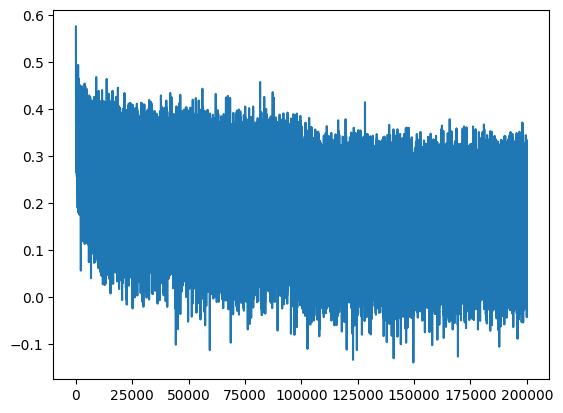

In [35]:
plt.plot(lossi)

In [36]:
split_loss('train', nn)
split_loss('dev', nn)

train 1.4796348810195923
dev 1.6903258562088013


### tanh

Reprenons notre réseau en repartant du loss initial:

In [37]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn_t = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
# Train
max_steps = 1
batch_size = 32
lossi = train(Xdev, Ydev, nn_t, max_steps, batch_size)

      0/      1: 3.7342


In [38]:
nn.h

tensor([[-1.0000,  0.9999, -1.0000,  ...,  1.0000,  1.0000, -1.0000],
        [-0.9768,  1.0000,  0.9727,  ..., -1.0000,  1.0000,  1.0000],
        [ 1.0000, -1.0000,  1.0000,  ...,  0.9166,  0.9992, -0.9738],
        ...,
        [-1.0000,  0.9999, -1.0000,  ...,  1.0000,  1.0000, -1.0000],
        [-0.9821, -0.9508,  1.0000,  ...,  0.9960,  1.0000, -1.0000],
        [ 1.0000, -1.0000,  1.0000,  ..., -0.5289,  0.9975, -1.0000]],
       grad_fn=<TanhBackward0>)

On peut voir que `h`, la couche cachée de notre réseau, a beaucoup de valeurs à $-1$ ou $1$.

In [39]:
nn.h.shape

torch.Size([32, 200])

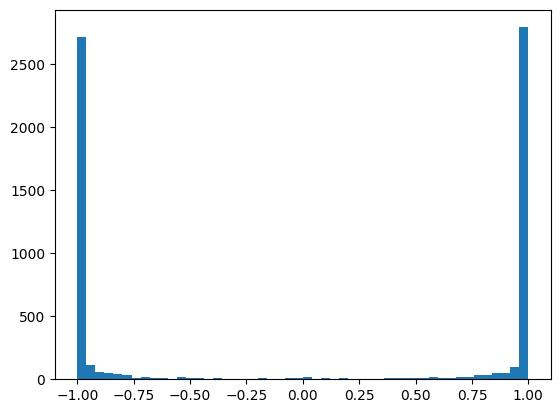

In [40]:
plt.hist(nn.h.view(-1).tolist(), 50);

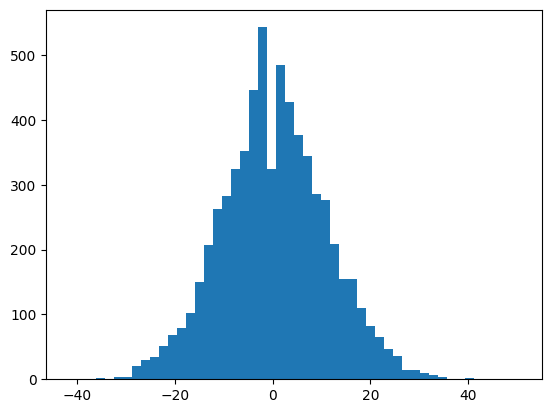

In [41]:
plt.hist(nn.hpreact.view(-1).tolist(), 50);

Beaucoup de nombres prennent des valeurs extrêmes, ce qui a un impact sur la qualité finale du réseau: beaucoup de valeurs passant "à travers" cette couche du réseau en remontant lors de la propagation arrière sont supprimées.

Voici la manière dont nous avions implémenté tanh dans notre travail sur micrograd:

```python
def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, children=(self,), op='tanh')
    def _backward():
        self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out
```

La valeur calculée $t$ est comprise entre $-1$ et $1$ ($\mathrm{tanh}$). Lors du calcul du gradient local, quand $t$ est proche de $-1$ ou $1$, on va "tuer" le gradient puisque $1-t^2$ sera égal à 0 et on va donc stopper la propagation arrière ici.

On peut améliorer cette situation, tout d'abord en visualisant tous les cas où les valeurs de `h` sont dans une région "plate" de la fonction $tanh$ (proches de $-1$ ou $1$), les cases blanches étant celles où c'est le cas:

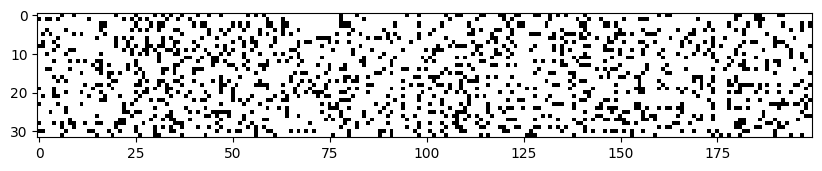

In [42]:
plt.figure(figsize=(10,500))
plt.imshow(nn.h.abs() > 0.99, cmap='gray', interpolation='nearest');

Si nous avions une colonne avec uniquement des cases blanches, cela signifierait que le neurone est mort et qu'il ne participe plus au fonctionnement général (aucun exemple ne l'a jamais activé), il n'apprendra plus ("_permanent brain damage_"). Cela ne semble pas être le cas ici.

Ce comportement n'est pas propre à la fonction $tanh$ et se retrouve dans toutes les [fonctions d'activation](https://fr.wikipedia.org/wiki/Fonction_d'activation).

Même si cette manière d'initialiser le réseau donne un _loss_ acceptable, il peut être amélioré en faisant en sorte qu'il y a ait moins de cases blanches: une manière de faire ceci est de réduire la plage de valeurs prises par la fonction de pré-activation `hpreact` et de faire en sorte que ces valeurs soient plus proches de 0.

      0/      1: 3.7404


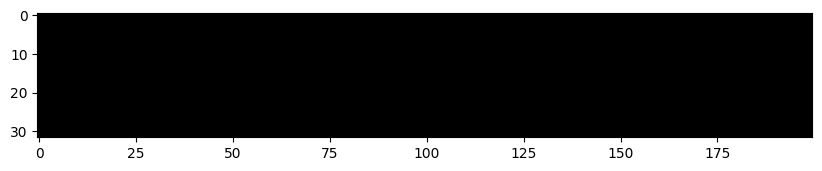

In [43]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
nn.b1 = nn.b1 * 0.01  # un peu d'entropie
nn.W1 = nn.W1 * 0.1
# Train
max_steps = 1
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
plt.figure(figsize=(10,500))
plt.imshow(nn.h.abs() > 0.99, cmap='gray', interpolation='nearest');

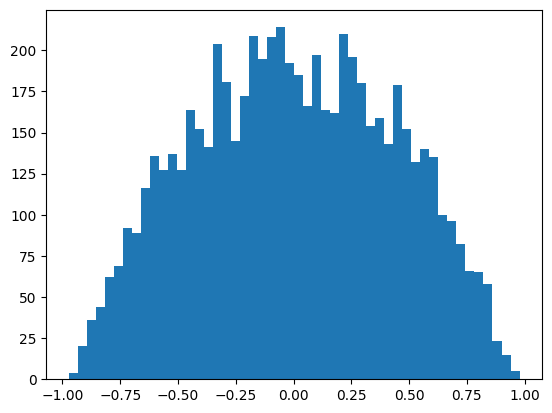

In [44]:
plt.hist(nn.h.view(-1).tolist(), 50);

      0/      1: 3.7560


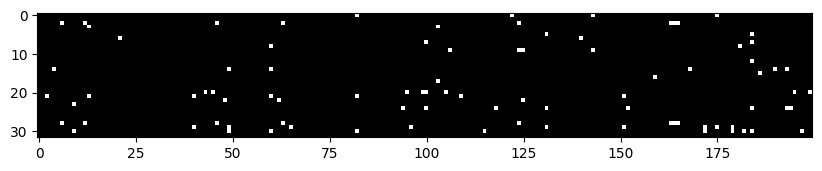

In [45]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
nn.b1 = nn.b1 * 0.01  # un peu d'entropie
nn.W1 = nn.W1 * 0.2
# Train
max_steps = 1
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
plt.figure(figsize=(10,500))
plt.imshow(nn.h.abs() > 0.99, cmap='gray', interpolation='nearest');

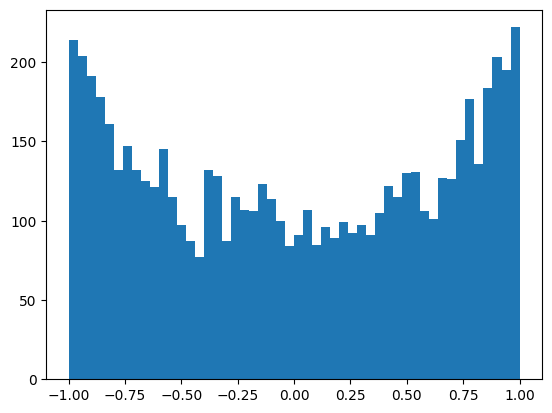

In [46]:
plt.hist(nn.h.view(-1).tolist(), 50);

In [47]:
class BengioMLP(object):
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.C = torch.randn((nb_chars, e_dims), generator=self.g)
        self.W1 = torch.randn((context_size*e_dims, n_hidden), generator=self.g) * 0.2
        self.b1 = torch.randn(n_hidden, generator=self.g) * 0.01
        self.W2 = torch.randn((n_hidden, nb_chars), generator=self.g) * 0.01
        self.b2 = torch.randn(nb_chars, generator=self.g) * 0.0
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.loss = None

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 + self.b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

      0/ 200000: 3.7560
  10000/ 200000: 2.0541
  20000/ 200000: 1.5766
  30000/ 200000: 1.2770
  40000/ 200000: 1.4517
  50000/ 200000: 1.6231
  60000/ 200000: 1.6299
  70000/ 200000: 1.4614
  80000/ 200000: 1.7319
  90000/ 200000: 1.3100
 100000/ 200000: 1.6475
 110000/ 200000: 1.4671
 120000/ 200000: 1.5099
 130000/ 200000: 1.3255
 140000/ 200000: 1.4925
 150000/ 200000: 1.4965
 160000/ 200000: 1.3950
 170000/ 200000: 1.4030
 180000/ 200000: 1.7534
 190000/ 200000: 1.6764


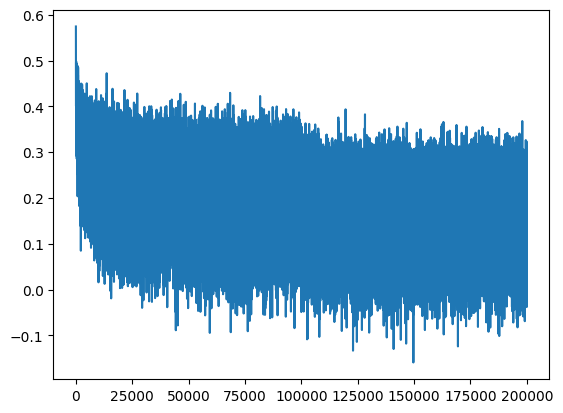

In [48]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
# Train
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
plt.plot(lossi)

In [49]:
split_loss('train', nn)
split_loss('dev', nn)

train 1.4537123441696167
dev 1.653684377670288


## Récapitulatif

*initial*

```
train 1.4944912195205688
dev 1.7210323810577393
```

*softmax*

```
train 1.4796348810195923
dev 1.6903258562088013
```

*tanh*

```
train 1.4537123441696167
dev 1.653684377670288
```

Sur un réseau aussi simple que celui que nous avons utilisé ici, les erreurs d'initialisation ont finalement peu d'impact sur la qualité finale du réseau. Par contre, sur des réseaux plus complexes, ces erreurs peuvent empêcher le réseau d'apprendre.

Nous avons pu ici modifier l'initialisation de manière empirique en ajoutant des "nombres magiques" (0.01, 0.2, etc.), mais il existe des techniques plus robustes pour trouver ces améliorations.

## Initialisation "Kaiming"

tensor(-0.0085) tensor(0.9915)
tensor(-0.0023) tensor(1.0042)


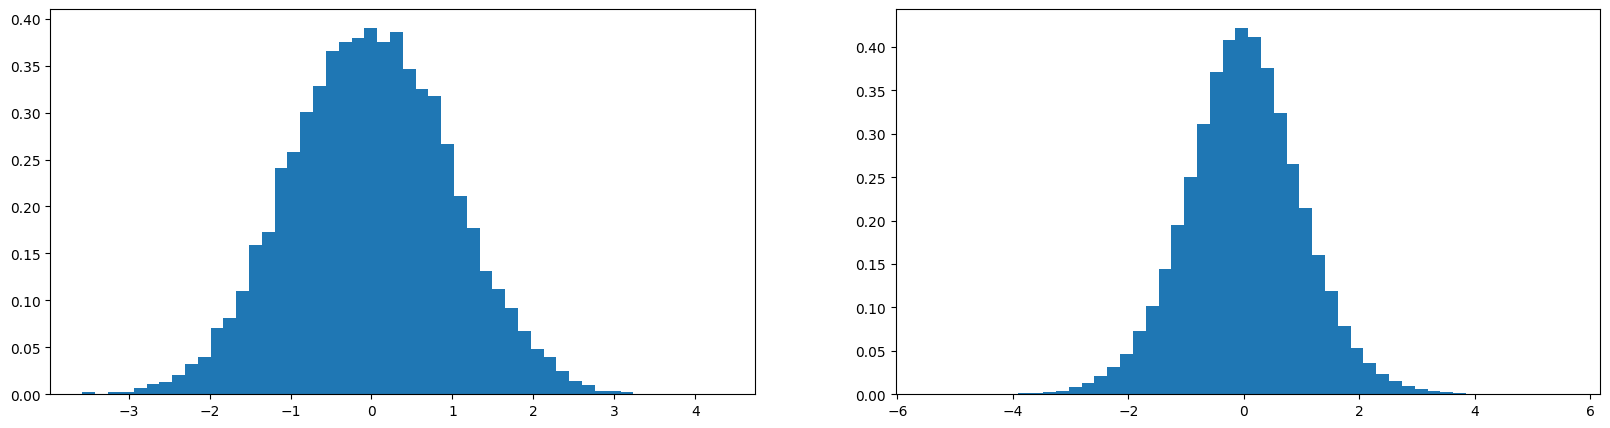

In [50]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

- Voir "Kaiming init" <https://arxiv.org/pdf/1502.01852>
- Voir <https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_>

In [51]:
class BengioMLP(object):
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.C = torch.randn((nb_chars, e_dims), generator=self.g)
        fan_in = context_size*e_dims
        self.W1 = torch.randn((fan_in, n_hidden), generator=self.g) * ((5/3) / (fan_in**0.5))
        self.b1 = torch.randn(n_hidden, generator=self.g) * 0.01
        self.W2 = torch.randn((n_hidden, nb_chars), generator=self.g) * 0.01
        self.b2 = torch.randn(nb_chars, generator=self.g) * 0.0
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.loss = None

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 + self.b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

      0/ 200000: 3.7641
  10000/ 200000: 1.9530
  20000/ 200000: 1.6099
  30000/ 200000: 1.2788
  40000/ 200000: 1.4439
  50000/ 200000: 1.6459
  60000/ 200000: 1.5960
  70000/ 200000: 1.4494
  80000/ 200000: 1.7521
  90000/ 200000: 1.3343
 100000/ 200000: 1.5650
 110000/ 200000: 1.4215
 120000/ 200000: 1.5127
 130000/ 200000: 1.2245
 140000/ 200000: 1.4151
 150000/ 200000: 1.4625
 160000/ 200000: 1.3742
 170000/ 200000: 1.3845
 180000/ 200000: 1.7178
 190000/ 200000: 1.6416


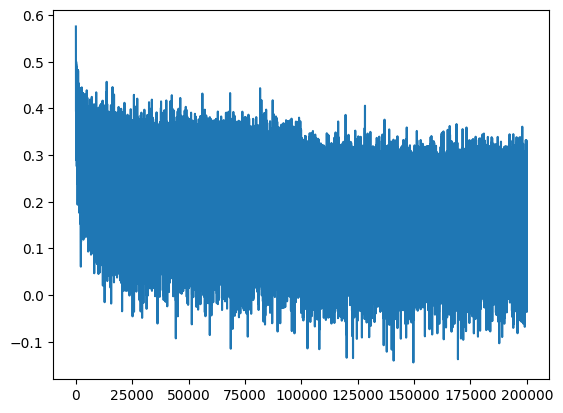

In [52]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
# Train
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
plt.plot(lossi)

In [53]:
split_loss('train', nn)
split_loss('dev', nn)

train 1.4532760381698608
dev 1.658145546913147


## Batch normalization

L'article de 2015 "_Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift_" de Sergey Ioffe de Christian Szegedy ([arxiv.org](https://arxiv.org/abs/1502.03167) a introduit la notion de "batch normalisation" qui a permis par la suite d'entraîner des réseaux de grande profondeur de manière beaucoup plus fiable et reproductible.

Dans la couche cachée (celle avec la non-linéarité due à $tanh$), les états de pré-activation `hpreact`:

```python
self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
```

ne doivent ni être trop petits ni trop grands, sinon ils sont "annulés" par la forme de $tanh$: on souhaiterait que la distribution de ces valeurs suive une loi normale. L'apport du papier de Ioffe et Szegedy est de partir de l'intuition qu'il suffit de normaliser les valeurs à l'initialisation pour qu'ils suivent une loi normale, avec des prescriptions sur la manière de le faire.

Ainsi, le papier indique qu'une normalisation qui "fonctionne bien" à l'initialisation est de partir d'un "batch" d'exemples $\mathcal{B} = {x_1, ..., x_m}$ qui correspondent dans notre code à:

```python
self.emb = self.C[X] # Embed characters into vectors
self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
self.hpreact = self.embcat @ self.W1 + self.b1 # hidden linear pre-activation layer
```

de faire la moyenne de ces valeurs ($\mu_\mathcal{B} = {1\over m} \sum_{i=1}^m{x_i}$):

```python
self.hpreact.mean(0)
```

et ensuite d'utiliser la variance ($\sigma_\mathcal{B}^2 = {1\over m} \sum_{i=1}^m{(x_i-\mu_\mathcal{B})^2}$) pour normaliser les valeurs avec la formule suivante:

$$\hat{x}_i = {{x_i - \mu_\mathcal{B}}\over{\sqrt{\sigma_\mathcal{B}^2 + \epsilon}}}$$

(avec $\epsilon$ qui permet d'éviter une division par zéro). Cette formule peut se traduire en code par ceci, en utilisant l'écart-type (`std` pour _standard deviation_):

```python
self.hpreact = self.hpreact - self.hpreact.mean(0) / self.hpreact.std(0)
```

Toutes ces fonctions sont dérivables donc nous pouvons calculer nos gradients.

En l’état cette formule est intéressante pour l'initialisation, mais le fait de forcer cette normalisation de cette manière ne va pas permettre d'obtenir de bons résultats lors de l'apprentissage.

Il faudrait adapter la distribution au fur et à mesure, en laissant la back-propagation nous dire quoi faire. L'approche "_scale and shift_" proposée dans le papier utilise la formule suivante:

$$y_i = {\gamma\hat{x}_i+\beta}$$

où $\gamma$ et $\beta$ sont deux nouveaux paramètres que nous allons faire apprendre à notre réseau, que nous appelerons `bngain` et `bnbias`:

```python
## initialisation
self.bngain = torch.ones()
self.bnbias = torch.zeros()
## forward
self.bnmeani = self.hpreact.mean(0, keepdim=True)
self.bnstdi = self.hpreact.std(0, keepdim=True)
self.hpreact = self.bngain * (self.hpreact - self.bnmeani) / self.bnstdi + self.bnbias
```

Cette normalisation de la couche cachée stabilise l’entraînement, en adaptant l’échelle de la couche de pré-activation.

Le prix à payer de cette approche est important: auparavant, chaque exemple avait une contribution indépendante pour l'apprentissage, maintenant sa contribution est reliée à ceux présents dans son batch à cause de la normalisation. En pratique cela permet de rendre l'apprentissage plus régulier quand on a un grand nombre de couches, dans une sorte d'_augmentation de données_ (_data augmentation_).

On peut supprimer `b1` dans le code car lorsque l’on soustrait `bmeani` ils sont annulés.

Cette approche implique également de revoir la manière dont l'inférence fonctionne car nous avons besoin de la valeur de la moyenne
de l'ensemble d'entraînement, ce qui est une opération qui peut être longue:

```python
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
```

Une approche plus courante est de "maintenir" cette moyenne et écart-type au cours de l'apprentissage dans la passe "forward":

```python
with torch.no_grad():
    self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * self.bnmeani
    self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * self.bnstdi
```

l'attribut `no_grad` permettant d'indiquer que les variables `*_running` ne font pas partie de notre réseau.

### Lien avec Pytorch

Pytorch propose des [Linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) qui correspondent aux couches que nous utilisons dans notre réseau: ce sont ces couches que l'on associe à des fonctions d'activation. Ces couches linéaires vont être la plupart du temps "normalisée" afin d'avoir des lois normales similaires en entrée et en sortie avant de passer à la couche non-linéaire.

La couche [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d) correspond à ce que nous avons utilisé ici.

D'autres couches de normalisation sont utilisées, comme [Layer Normalization](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).

Voici en synthèse le nouveau code de notre réseau, avec l'inférence associée.

In [54]:
class BengioMLP(object):
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.C = torch.randn((nb_chars, e_dims), generator=self.g)
        fan_in = context_size*e_dims
        self.W1 = torch.randn((fan_in, n_hidden), generator=self.g) * ((5/3) / (fan_in**0.5))
        #self.b1 = torch.randn(n_hidden, generator=self.g) * 0.01
        self.W2 = torch.randn((n_hidden, nb_chars), generator=self.g) * 0.01
        self.b2 = torch.randn(nb_chars, generator=self.g) * 0.0
        self.bngain = torch.ones((1, n_hidden))
        self.bnbias = torch.zeros((1, n_hidden))
        self.parameters = [self.C, self.W1, self.W2, self.b2, self.bngain, self.bnbias]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True
        self.bnmean_running = torch.zeros((1, n_hidden))
        self.bnstd_running = torch.zeros((1, n_hidden))
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.loss = None

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        # Linear layer
        self.hpreact = self.embcat @ self.W1 #+ self.b1 # hidden layer pre-activation
        # BatchNorm layer
        self.bnmeani = self.hpreact.mean(0, keepdim=True)
        self.bnstdi = self.hpreact.std(0, keepdim=True)
        self.hpreact = self.bngain * (self.hpreact - self.bnmeani) / self.bnstdi + self.bnbias
        # Non linearity
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function
        # mean, std
        with torch.no_grad():
            self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * self.bnmeani
            self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * self.bnstdi

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 # + self.b1 # hidden layer pre-activation
        hpreact = self.bngain * (hpreact - self.bnmean_running) / self.bnstd_running + self.bnbias
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

      0/ 200000: 3.6951
  10000/ 200000: 1.7546
  20000/ 200000: 1.5343
  30000/ 200000: 2.1442
  40000/ 200000: 2.2356
  50000/ 200000: 1.7096
  60000/ 200000: 1.4065
  70000/ 200000: 1.6366
  80000/ 200000: 1.7008
  90000/ 200000: 1.7373
 100000/ 200000: 1.9293
 110000/ 200000: 1.6959
 120000/ 200000: 1.2426
 130000/ 200000: 1.6244
 140000/ 200000: 1.8518
 150000/ 200000: 1.6683
 160000/ 200000: 1.4990
 170000/ 200000: 1.4946
 180000/ 200000: 1.8170
 190000/ 200000: 1.6727


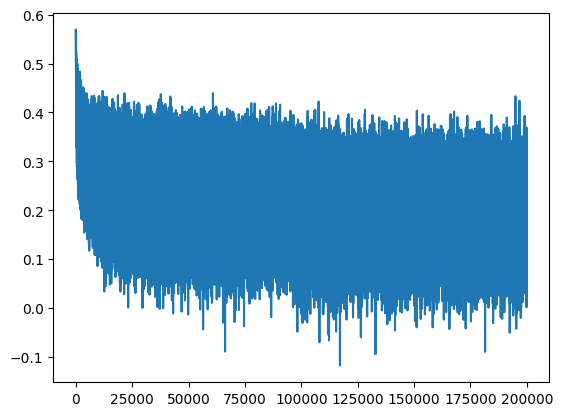

In [55]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
# Train
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
plt.plot(lossi)

In [56]:
split_loss('train', nn)
split_loss('dev', nn)

train 1.5234135389328003
dev 1.6634995937347412


*initial*

```
train 1.4944912195205688
dev 1.7210323810577393
```

*softmax*

```
train 1.4796348810195923
dev 1.6903258562088013
```

*tanh*

```
train 1.4537123441696167
dev 1.653684377670288
```

*kaiming*

```
train 1.4532760381698608
dev 1.658145546913147
```

*batch normalization*

```
train 1.5259160995483398
dev 1.662747859954834
```


In [57]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

@torch.no_grad()
def sample(itoc, nn, g):
    out = []
    context = [0] * nn.context_size
    while True:
        emb = nn.C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ nn.W1
        hpreact = nn.bngain * (hpreact - nn.bnmean_running) / nn.bnstd_running + nn.bnbias
        h = torch.tanh(hpreact)
        logits = h @ nn.W2 + nn.b2
        probs = F.softmax(logits, dim=1)
        # Sample from the probability distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window
        context = context[1:] + [ix]
        # Store the generated character
        if ix != 0:
            out.append(ix)
        else:
            # Stop when encounting '.'
            break
    return ''.join(itoc[i] for i in out)

for _ in range(20):
    print(sample(words.itoc, nn, g))

aveilles
saientients
sociale
apprétaire
sucunzlarieurs
déter
soire
accuei
unider
groges
moduites
judividabé
solèvement
exceptir
évalus
jourles
interniteprof
recouplie
nif
minégataire


## EXERCICE: tout à zéro

In [58]:
class BengioMLP(object):
    
    def __init__(self, e_dims, n_hidden, context_size, nb_chars, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.C = torch.zeros((nb_chars, e_dims))
        self.W1 = torch.zeros((context_size*e_dims, n_hidden))
        self.b1 = torch.zeros(n_hidden)
        self.W2 = torch.zeros((n_hidden, nb_chars))
        self.b2 = torch.zeros(nb_chars)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        self.nb_parameters = sum(p.nelement() for p in self.parameters) # number of parameters in total
        for p in self.parameters:
            p.requires_grad = True
        self.nb_chars = nb_chars
        self.e_dims = e_dims
        self.n_hidden = n_hidden
        self.context_size = context_size
        self.loss = None

    def forward(self, X, Y):
        self.emb = self.C[X] # Embed characters into vectors
        self.embcat = self.emb.view(self.emb.shape[0], -1) # Concatenate the vectors
        self.hpreact = self.embcat @ self.W1 + self.b1 # hidden layer pre-activation
        self.h = torch.tanh(self.hpreact) # hidden layer
        self.logits = self.h @ self.W2 + self.b2 # output layer
        self.loss = F.cross_entropy(self.logits, Y) # loss function

    def backward(self):
        for p in self.parameters:
            p.grad = None
        self.loss.backward()

    def update_grad(self, lr):
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def compute_loss(self, X, Y):
        emb = self.C[X] # Embed characters into vectors
        embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
        hpreact = embcat @ self.W1 + self.b1 # hidden layer pre-activation
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ self.W2 + self.b2 # output layer
        loss = F.cross_entropy(logits, Y) # loss function
        return loss

    def __repr__(self):
        l = []
        l.append("<BengioMLP")
        l.append(f'  nb_chars="{self.nb_chars}"')
        l.append(f'  e_dims="{self.e_dims}"')
        l.append(f'  n_hidden="{self.n_hidden}"')
        l.append(f'  context_size="{self.context_size}"')
        l.append(f'  loss="{self.loss}"')
        l.append(f'  nb_parameters="{self.nb_parameters}"/>')
        return '\n'.join(l)

      0/ 200000: 3.7136
  10000/ 200000: 3.0745
  20000/ 200000: 2.9657
  30000/ 200000: 3.1396
  40000/ 200000: 3.1494
  50000/ 200000: 2.8236
  60000/ 200000: 2.6923
  70000/ 200000: 2.9324
  80000/ 200000: 2.9869
  90000/ 200000: 2.9819
 100000/ 200000: 2.8179
 110000/ 200000: 3.0233
 120000/ 200000: 2.8946
 130000/ 200000: 2.8120
 140000/ 200000: 2.8029
 150000/ 200000: 2.9380
 160000/ 200000: 2.8480
 170000/ 200000: 2.9795
 180000/ 200000: 3.0869
 190000/ 200000: 2.7934


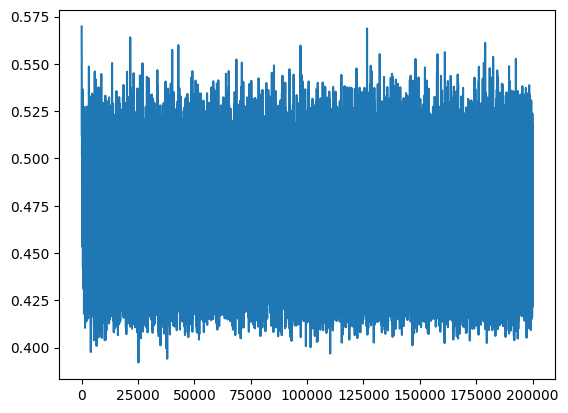

In [59]:
# Network
e_dims = 10  # Dimensions des embeddings
n_hidden = 200
context_size = 3
nn = BengioMLP(e_dims, n_hidden, context_size, words.nb_chars)
# Train
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, nn, max_steps, batch_size)
plt.plot(lossi)